In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [ ]:
df= pd.read_csv("csv_grafo.csv")
df.head()

,node_id,nombre,label,features,Habit,Action_class,Chemical_class
0,0,augmentin 625 duo tablet,ANTI INFECTIVES,"[0.32182204723358154, 0.04244845360517502, 0.0...",No,NaN,NaN
1,1,azithral 500 tablet,ANTI INFECTIVES,"[0.4727298617362976, 0.1994362771511078, 0.022...",No,Macrolides,Macrolides
2,2,ascoril ls syrup,RESPIRATORY,"[0.12347780913114548, -0.03995594009757042, 0....",No,NaN,NaN
3,3,allegra 120mg tablet,RESPIRATORY,"[0.12502261996269226, -0.15132544934749603, 0....",No,H1 Antihistaminics (second Generation),Diphenylmethane Derivative
4,4,avil 25 tablet,RESPIRATORY,"[-0.0325993150472641, -0.2202097326517105, 0.1...",No,H1 Antihistaminics (First Generation),Pyridines Derivatives


In [ ]:
df['label'].value_counts()

,count
label,
ANTI INFECTIVES,909
PAIN ANALGESICS,845
RESPIRATORY,715
CARDIAC,675
NEURO CNS,498
GASTRO INTESTINAL,281
DERMA,234
OPHTHAL,172
VITAMINS MINERALS NUTRIENTS,144


In [ ]:
df['features'] = df['features'].apply(eval)

X = np.vstack(df['features'].values)

In [ ]:
print(X.shape)

(5000, 128)


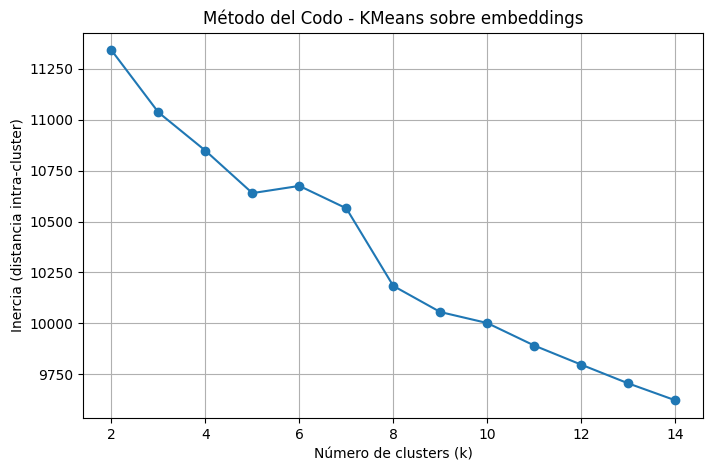

In [ ]:
inertias = []
k_range = range(2, 15)

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=22)
  kmeans.fit(X)
  inertias.append(kmeans.inertia_)

# método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (distancia intra-cluster)")
plt.title("Método del Codo - KMeans sobre embeddings")
plt.grid(True)
plt.show()

In [ ]:
# Definir el número de clusters
kmeans = KMeans(n_clusters=12, random_state=22)
df['cluster'] = kmeans.fit_predict(X)

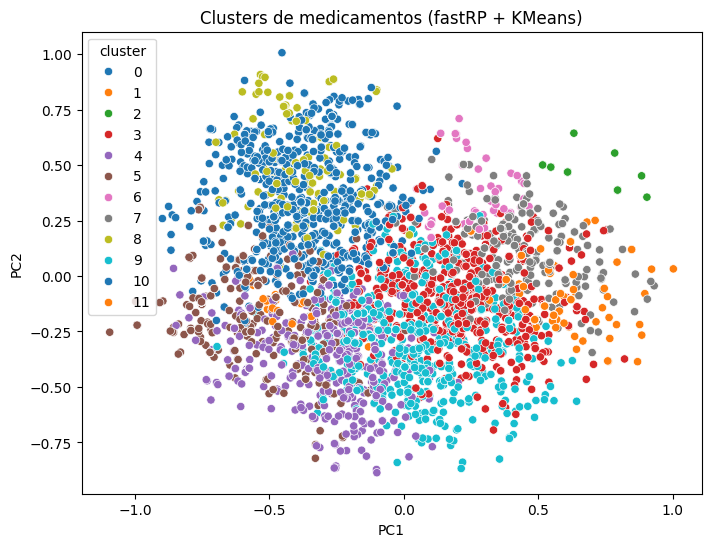

In [ ]:
# 2D
pca = PCA(n_components=7)
X_2d = pca.fit_transform(X)
df['PC1'], df['PC2'] = X_2d[:, 0], X_2d[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("Clusters de medicamentos (fastRP + KMeans)")
plt.show()

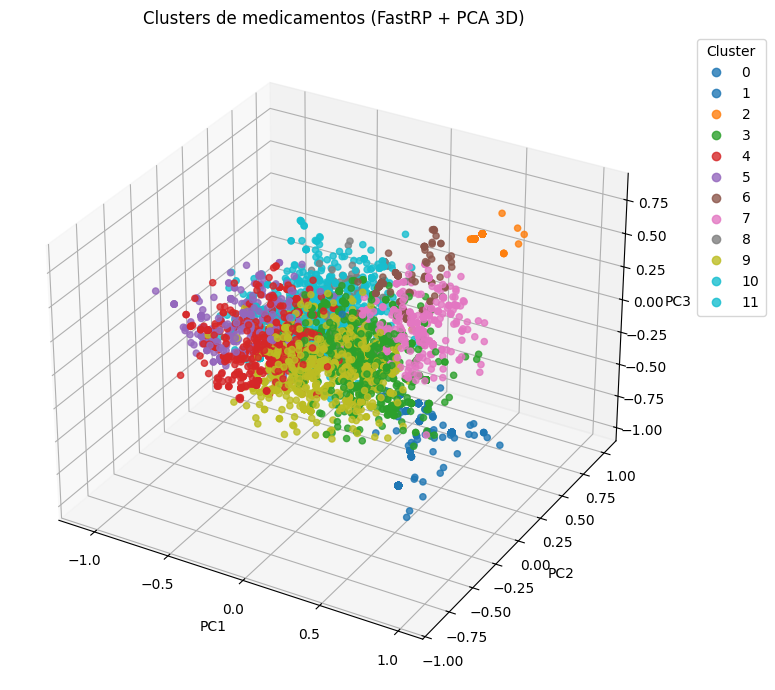

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Reducir a 3 componentes principales
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)

df['PC1'], df['PC2'], df['PC3'] = X_3d[:, 0], X_3d[:, 1], X_3d[:, 2]

# 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['PC1'],
    df['PC2'],
    df['PC3'],
    c=df['cluster'],
    cmap='tab10',
    s=20,
    alpha=0.8
)

ax.set_title("Clusters de medicamentos (FastRP + PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
score = silhouette_score(df[['PC1', 'PC2', 'PC3']], df['cluster'])
print(f"Silhouette score (PCA 3D space): {score:.3f}")

Silhouette score (PCA 3D space): 0.042


In [ ]:
output_lines = []

for c in sorted(df['cluster'].unique()):
  cluster_df = df[df['cluster'] == c]
  output_lines.append(f"--- Cluster {c} ---")
  output_lines.append(f"Total de elementos: {len(cluster_df)}")

  clases_terapeuticas = cluster_df['label'].dropna().unique()
  output_lines.append(f"Clases terapéuticas únicas ({len(clases_terapeuticas)}): {clases_terapeuticas.tolist()}")

  output_lines.append("\nFrecuencia de clases terapéuticas:")
  output_lines.append(cluster_df['label'].value_counts().to_string())

  output_lines.append("\nPrimeros 10 elementos:")
  output_lines.append(cluster_df[['node_id', 'nombre', 'label', 'Action_class']].head(10).to_string(index=False))
  output_lines.append("\n" + "-"*50 + "\n")

# Guardar en archivo
with open("clusters_resumen.txt", "w", encoding="utf-8") as f:
  f.write("\n".join(output_lines))


In [ ]:
# Definir el número de clusters
kmeans = KMeans(n_clusters=8, random_state=22)

df['cluster'] = kmeans.fit_predict(X)

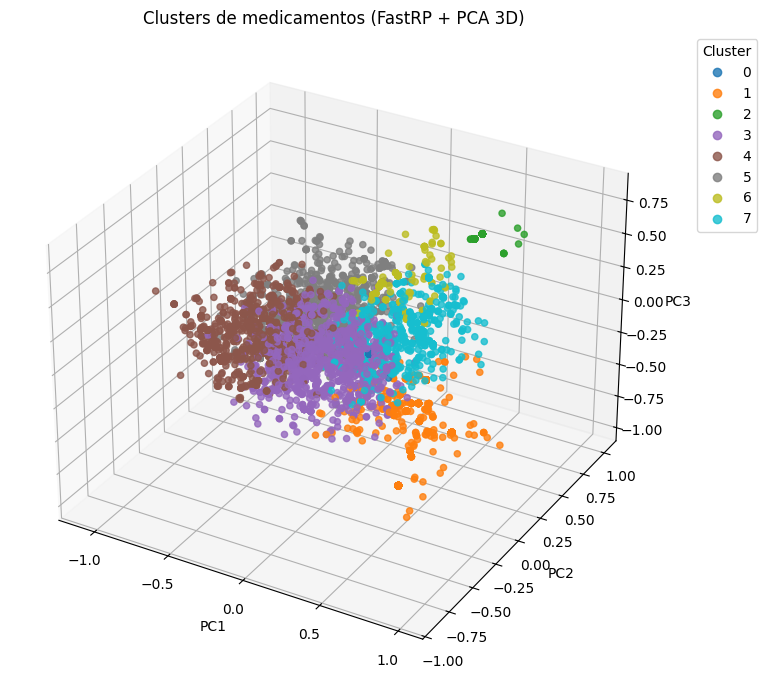

In [ ]:
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)
df['PC1'], df['PC2'], df['PC3'] = X_3d[:, 0], X_3d[:, 1], X_3d[:, 2]

# 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['PC1'],
    df['PC2'],
    df['PC3'],
    c=df['cluster'],
    cmap='tab10',
    s=20,
    alpha=0.8
)

ax.set_title("Clusters de medicamentos (FastRP + PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
output_lines = []

for c in sorted(df['cluster'].unique()):
  cluster_df = df[df['cluster'] == c]
  output_lines.append(f"--- Cluster {c} ---")
  output_lines.append(f"Total de elementos: {len(cluster_df)}")

  clases_terapeuticas = cluster_df['label'].dropna().unique()
  output_lines.append(f"Clases terapéuticas únicas ({len(clases_terapeuticas)}): {clases_terapeuticas.tolist()}")

  output_lines.append("\nFrecuencia de clases terapéuticas:")
  output_lines.append(cluster_df['label'].value_counts().to_string())

  output_lines.append("\nPrimeros 10 elementos:")
  output_lines.append(cluster_df[['node_id', 'nombre', 'label', 'Action_class']].head(10).to_string(index=False))
  output_lines.append("\n" + "-"*50 + "\n")

# Guardar en archivo
with open("clusters_resumen8.txt", "w", encoding="utf-8") as f:
  f.write("\n".join(output_lines))

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
df['cluster_hdb'] = clusterer.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


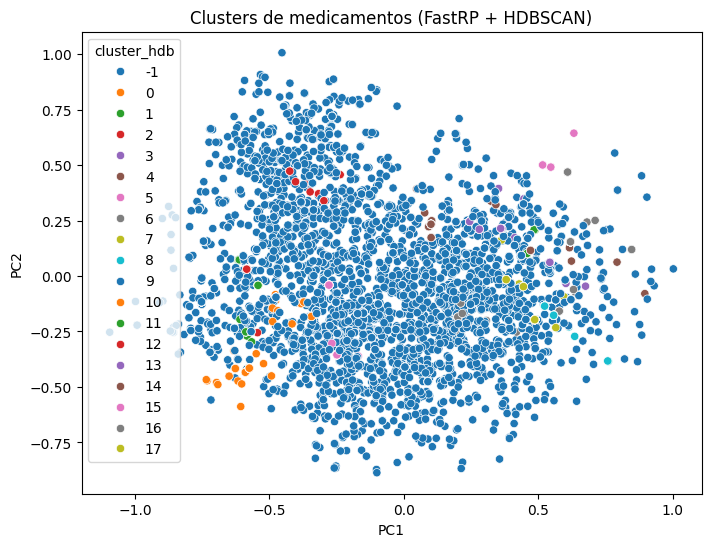

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_hdb', palette='tab10', legend='full')
plt.title("Clusters de medicamentos (FastRP + HDBSCAN)")
plt.show()

In [ ]:
output_lines = []

for c in sorted(df['cluster_hdb'].unique()):
  cluster_df_hdb = df[df['cluster_hdb'] == c]
  output_lines.append(f"--- Cluster {c} ---")
  output_lines.append(f"Total de elementos: {len(cluster_df_hdb)}")

  clases_terapeuticas = cluster_df_hdb['label'].dropna().unique()
  output_lines.append(f"Clases terapéuticas únicas ({len(clases_terapeuticas)}): {clases_terapeuticas.tolist()}")

  output_lines.append("\nFrecuencia de clases terapéuticas:")
  output_lines.append(cluster_df_hdb['label'].value_counts().to_string())

  output_lines.append("\nPrimeros 10 elementos:")
  output_lines.append(cluster_df_hdb[['node_id', 'nombre', 'label', 'Action_class']].head(10).to_string(index=False))
  output_lines.append("\n" + "-"*50 + "\n")

# Guardar en archivo
with open("clusters_resumenHDBSCAN.txt", "w", encoding="utf-8") as f:
  f.write("\n".join(output_lines))

In [ ]:
# borrar nan
df = df.dropna(subset=['label'])

# variables
X = np.vstack(df['features'].values)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=22, stratify=y_encoded)

In [ ]:
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [ ]:
results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  results.append((name, acc, f1))


results_df = pd.DataFrame(results, columns=['Modelo', 'Accuracy', 'F1 Score']).sort_values('F1 Score', ascending=False)
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


         Modelo  Accuracy  F1 Score
3           SVM     0.914  0.907991
4       XGBoost     0.882  0.876639
2           KNN     0.867  0.864415
1  RandomForest     0.855  0.845359
0        LogReg     0.843  0.834540


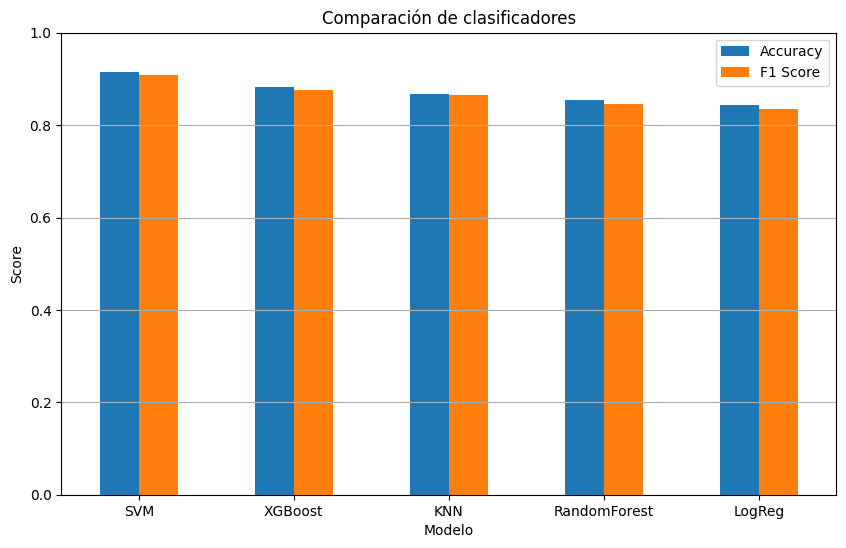

In [ ]:
results_df.plot(x='Modelo', y=['Accuracy', 'F1 Score'], kind='bar', figsize=(10, 6), ylim=(0, 1), title='Comparación de clasificadores')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()

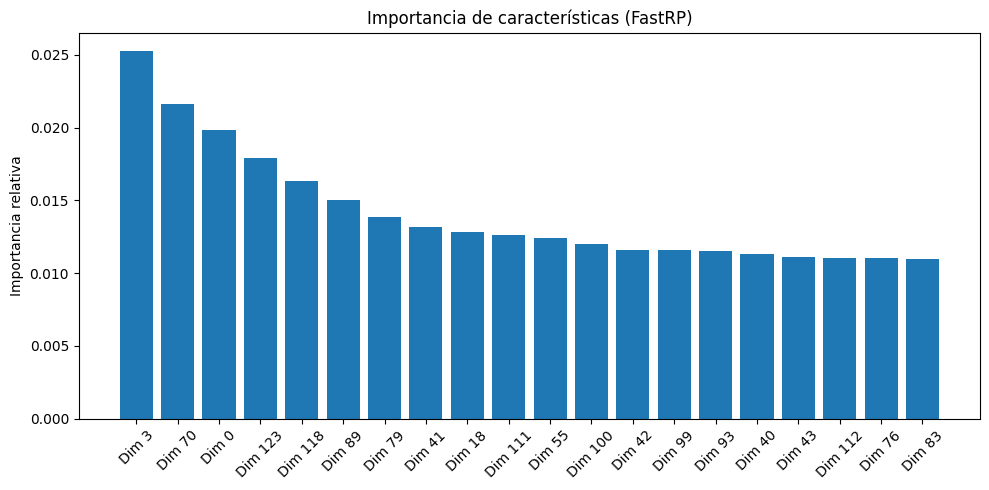

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=22)
rf.fit(X_train, y_train)

# importancias
importancias = rf.feature_importances_
indices = np.argsort(importancias)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(20), importancias[indices[:20]])
plt.xticks(range(20), [f'Dim {i}' for i in indices[:20]], rotation=45)
plt.title("Importancia de características (FastRP)")
plt.ylabel("Importancia relativa")
plt.tight_layout()
plt.show()

In [ ]:
importancias.mean()

np.float64(0.0078125)

In [ ]:
total = len(df)
nulos = df['Action_class'].isna().sum()
no_nulos = total - nulos
porc_nulos = nulos / total * 100
porc_util = 100 - porc_nulos
distintos = df['Action_class'].nunique()

print(f"Total de filas: {total}")
print(f"Nulos en ActionClass: {nulos} ({porc_nulos:.2f}%)")
print(f"Disponibles para clasificación: {no_nulos} ({porc_util:.2f}%)")
print(f"Distintos: {distintos}")

Total de filas: 4997
Nulos en ActionClass: 2390 (47.83%)
Disponibles para clasificación: 2607 (52.17%)
Distintos: 225


In [ ]:
counts = df['Action_class'].value_counts()
valid_classes = counts[counts >= 2].index
df_action = df[df['Action_class'].isin(valid_classes)]

X = np.vstack(df_action['features'].values)
y = df_action['Action_class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=22)

In [ ]:
# opcional: XGBoost
try:
  from xgboost import XGBClassifier
  use_xgb = True
except ImportError:
  use_xgb = False

models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC()
}

In [ ]:
results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")
  results.append((name, acc, f1))

results_df = pd.DataFrame(results, columns=['Modelo', 'Accuracy', 'F1 Score']).sort_values('F1 Score', ascending=False)
print(results_df)

         Modelo  Accuracy  F1 Score
1  RandomForest  0.861328  0.836601
3           SVM  0.855469  0.826460
0        LogReg  0.851562  0.814680
2           KNN  0.808594  0.783844


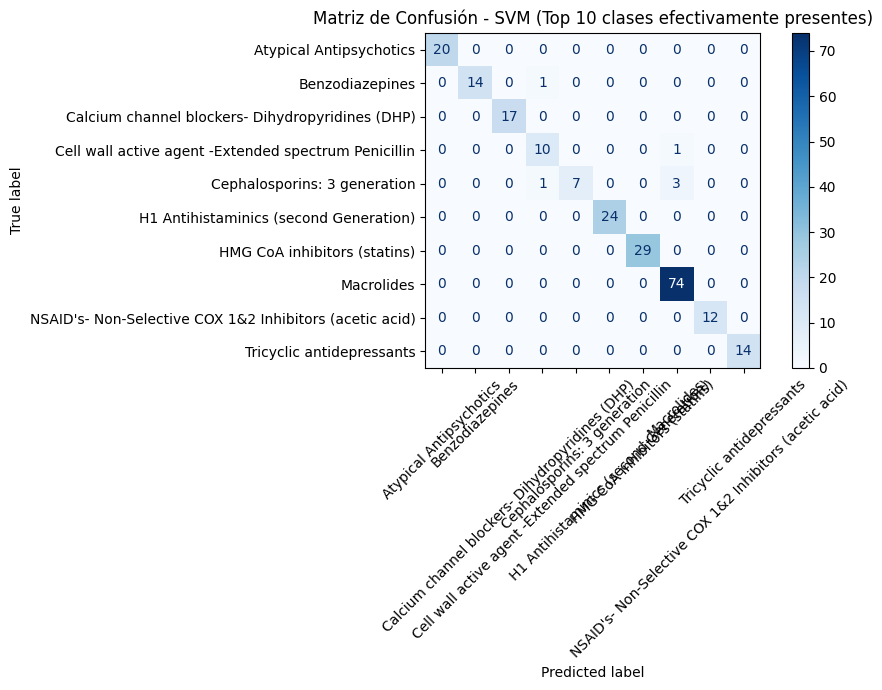

In [ ]:
# tomar los 10 mejores
top_k = 10
top_classes = [cls for cls, _ in Counter(y_test).most_common(top_k)]
top_classes = np.array(top_classes)

mask = np.isin(y_test, top_classes) & np.isin(y_pred, top_classes)
y_test_top = y_test[mask]
y_pred_top = y_pred[mask]

# orden
classes_present = np.unique(np.concatenate([y_test_top, y_pred_top]))
cm_top = confusion_matrix(y_test_top, y_pred_top, labels=classes_present)
labels_top = le.inverse_transform(classes_present)

# cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels_top)
fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title(f"Matriz de Confusión - {name} (Top {top_k} clases efectivamente presentes)")
plt.tight_layout()
plt.show()


In [ ]:
df_habit = df.dropna(subset=['Habit'])
X = np.vstack(df_habit['features'].values)

# cambio Yes/No como 1/0
le_habit = LabelEncoder()
y = le_habit.fit_transform(df_habit['Habit'])  # Yes -> 1 No -> 0

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

In [ ]:
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC()
}

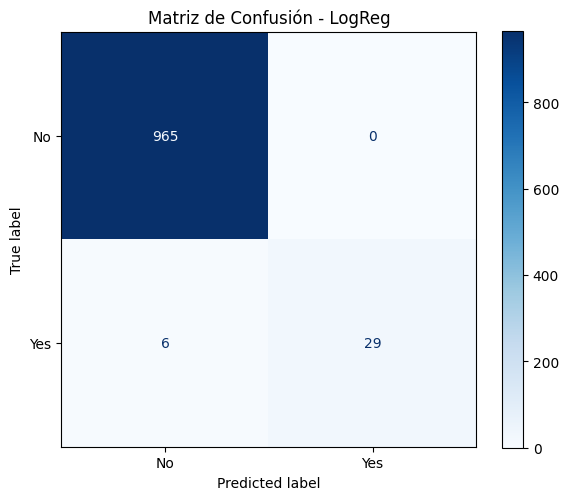

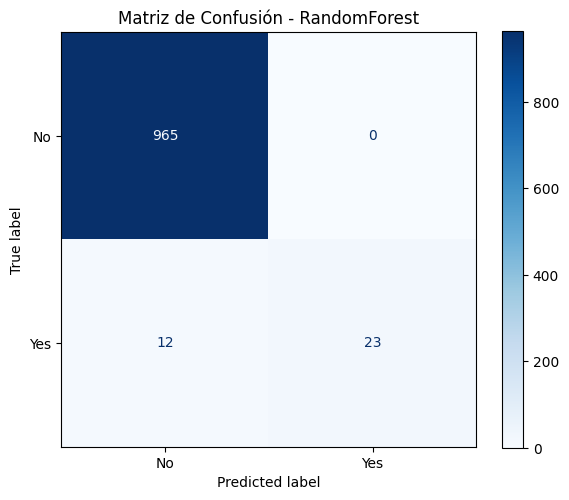

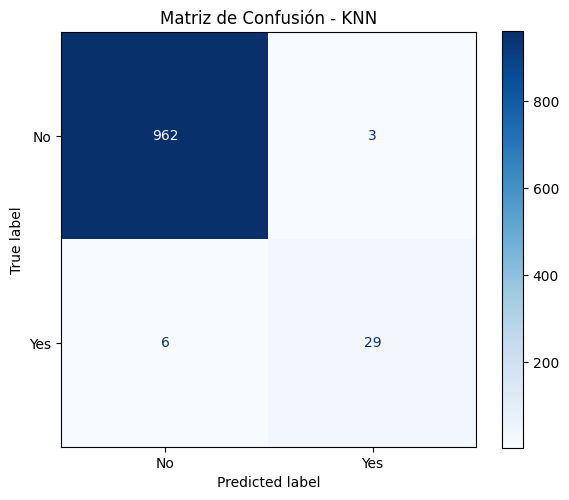

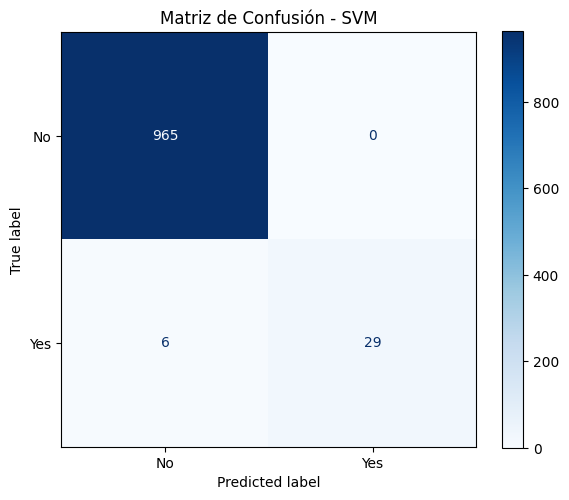

         Modelo  Accuracy  F1 Score
0        LogReg     0.994  0.906250
3           SVM     0.994  0.906250
2           KNN     0.991  0.865672
1  RandomForest     0.988  0.793103


In [ ]:
results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  results.append((name, acc, f1))

  # cm
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_habit.classes_)
  fig, ax = plt.subplots(figsize=(6, 5))
  disp.plot(cmap='Blues', ax=ax)
  plt.title(f"Matriz de Confusión - {name}")
  plt.grid(False)
  plt.tight_layout()
  plt.show()

results_df = pd.DataFrame(results, columns=['Modelo', 'Accuracy', 'F1 Score']).sort_values('F1 Score', ascending=False)
print(results_df)